In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm as tqdm


In [2]:
# === PART 1 OF Q3.1 ===

# Load preprocessed datasets
df_a = pd.read_parquet('ml_ready_data/set-a-scaled.parquet')  # Train set
df_b = pd.read_parquet('ml_ready_data/set-b-scaled.parquet')
df_c = pd.read_parquet('ml_ready_data/set-c-scaled.parquet')  # Test set

In [3]:
static_vars = ['Age', 'Gender', 'Height', 'Weight']

# Extract time_series_vars separately for each dataset
time_series_vars_a = [col for col in df_a.columns if col not in static_vars + ['Hour', 'PatientID', 'RecordID', 'In_hospital_death']]
time_series_vars_b = [col for col in df_b.columns if col not in static_vars + ['Hour', 'PatientID', 'RecordID', 'In_hospital_death']]
time_series_vars_c = [col for col in df_c.columns if col not in static_vars + ['Hour', 'PatientID', 'RecordID', 'In_hospital_death']]

# Extract full data for each dataset using its own time series variables
full_data_a = df_a[static_vars + time_series_vars_a]
full_data_b = df_b[static_vars + time_series_vars_b]
full_data_c = df_c[static_vars + time_series_vars_c]

# Print shapes to verify
print("full_data_a shape:", full_data_a.shape)
print("full_data_b shape:", full_data_b.shape)
print("full_data_c shape:", full_data_c.shape)


full_data_a shape: (196000, 41)
full_data_b shape: (196000, 41)
full_data_c shape: (196000, 41)


# InfoNCE loss handling multiple negatives using batch matrix multiplication (bmm)

In [4]:
import torch
import torch.nn.functional as F

def info_nce_loss(anchor, positive, negatives, temperature=0.1):
    """
    Computes the InfoNCE loss for contrastive learning.

    Args:
    - anchor: Tensor of shape (batch_size, embedding_dim)
    - positive: Tensor of shape (batch_size, embedding_dim)
    - negatives: Tensor of shape (batch_size, num_negatives, embedding_dim)
    - temperature: Temperature scaling parameter

    Returns:
    - loss: Scalar tensor representing the InfoNCE loss
    """

    # Compute cosine similarity between anchor and positive (shape: batch_size,)
    positive_similarity = F.cosine_similarity(anchor, positive, dim=-1)

    # Compute cosine similarity between anchor and each negative sample
    negatives = negatives.view(anchor.shape[0], -1, anchor.shape[1])  # Ensure correct shape
    negative_similarity = torch.bmm(negatives, anchor.unsqueeze(-1)).squeeze(-1)  # Shape: (batch_size, num_negatives)

    # Apply temperature scaling
    positive_similarity = positive_similarity / temperature
    negative_similarity = negative_similarity / temperature

    # Stack positive similarity and negative similarities together
    logits = torch.cat([positive_similarity.unsqueeze(1), negative_similarity], dim=1)  # (batch_size, 1 + num_negatives)

    # Labels: first column corresponds to the positive pair
    labels = torch.zeros(logits.size(0), dtype=torch.long, device=anchor.device)

    # Compute cross-entropy loss
    loss = F.cross_entropy(logits, labels)
    
    return loss


# Create Anchor, 1x Positive, multiple Negatives

In [6]:
import numpy as np
import random

def create_positive_negative_pairs(df, time_series_vars, static_vars, seq_length=48, window_size=12, num_negatives=5):
    """
    Create positive and multiple negative pairs from time-series data for contrastive learning.
    
    Args:
    - df: The dataframe containing the time-series data for all patients.
    - time_series_vars: List of time-series variable names (37 time-series variables).
    - seq_length: Length of the time-series sequence (e.g., 48 hours).
    - window_size: Length of each time-series window (e.g., 12 hours).
    - num_negatives: Number of negative samples per positive pair.
    
    Returns:
    - positive_pairs: List of tuples (xref, xpos) for positive pairs.
    - negative_pairs: List of tuples (xref, [xneg1, xneg2, ..., xnegN]) for negative pairs.
    """
    positive_pairs = []
    negative_pairs = []
    
    grouped = df.groupby('PatientID')
    patient_ids = df['PatientID'].unique()

    # Iterate over each patient
    for patient_id, patient_data in grouped:
        time_series_data = patient_data[time_series_vars + static_vars].values
        
        if len(time_series_data) < seq_length:
            continue
        
        for i in range(0, seq_length - window_size, window_size):  
            xpos = time_series_data[i:i+window_size]  
            xref = time_series_data[i+window_size:i+2*window_size]  

            if xref.shape[0] == window_size:
                positive_pairs.append((xref, xpos))
                
                # Select multiple negatives from different patients
                negative_samples = []
                sampled_patient_ids = random.sample([pid for pid in patient_ids if pid != patient_id], num_negatives)

                for other_patient_id in sampled_patient_ids:
                    other_patient_data = df[df['PatientID'] == other_patient_id][time_series_vars + static_vars].values
                    if len(other_patient_data) >= seq_length:
                        xneg = other_patient_data[:window_size]  
                        negative_samples.append(xneg)

                if len(negative_samples) == num_negatives:
                    negative_pairs.append((xref, np.array(negative_samples)))  # Shape: (xref, num_negatives, window_size, features)

    min_len = min(len(positive_pairs), len(negative_pairs))
    positive_pairs = positive_pairs[:min_len]
    negative_pairs = negative_pairs[:min_len]

    return positive_pairs, negative_pairs

# Example usage:
positive_pairs, negative_pairs = create_positive_negative_pairs(df_a, time_series_vars_a, static_vars, num_negatives=5)   # creating positive/negative pairs using train dataframe df_a..

# Print a sample positive and negative pair
print(f"Sample Positive Pair: {positive_pairs[0]}")
print(f"Sample Negative Pair Shape: {negative_pairs[0][1].shape}")  # Should print (num_negatives, window_size, num_features)


Sample Positive Pair: (array([[-0.46666667, -0.33333333,  0.        ,  0.        ,  0.16666667,
         2.10810811,  0.75      ,  0.58181818, -1.2173913 ,  4.        ,
         0.6       ,  0.        ,  0.        , -1.25      , -1.30769231,
        -1.15003751, -0.80952381, -0.5       ,  0.        ,  0.        ,
         0.48484848,  0.        ,  0.        ,  0.55555556, -0.18181818,
        -0.03571429,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -7.        ,  0.        , -0.51485149, -1.        , -0.89602804,
        -2.71591909],
       [-0.46666667, -0.33333333,  0.        ,  0.        ,  0.16666667,
         2.10810811,  0.75      ,  0.58181818, -1.13043478,  4.        ,
         0.6       ,  0.        ,  0.        , -1.25      , -0.76923077,
        -0.69992498, -0.61904762, -0.5       ,  0.        ,  0.        ,
         0.48484848,  0.        ,  0.        ,  0.55555556, -0.09090909,
      

In [7]:
print(positive_pairs[0][0].shape) #print shape of first positive pair, namely the reference time series window
print(positive_pairs[0][1].shape) #" of the second positive pair, another time window of the same patient
print(len(positive_pairs) == len(negative_pairs))
print(len(positive_pairs))
print(negative_pairs[0][0].shape)
print(negative_pairs[0][1].shape)

print(positive_pairs[1][0].shape)

(12, 41)
(12, 41)
True
12000
(12, 41)
(5, 12, 41)
(12, 41)


# DataLoader with multiple Negatives

In [8]:
import torch

class ContrastiveLearningDataset(torch.utils.data.Dataset):
    def __init__(self, positive_pairs, negative_pairs):
        self.positive_pairs = positive_pairs  # List of (xref, xpos)
        self.negative_pairs = negative_pairs  # List of (xref, [xneg1, xneg2, ...])

    def __len__(self):
        assert len(self.positive_pairs) == len(self.negative_pairs), "Mismatch in positive and negative pairs length"
        return len(self.positive_pairs)

    def __getitem__(self, idx):
        # Positive pair
        xref_pos, xpos = self.positive_pairs[idx]  # (xref, xpos)
        
        # Negative samples (multiple)
        xref_neg, xneg_list = self.negative_pairs[idx]  # (xref, [xneg1, xneg2, ...])
        
        # Convert to tensors
        xref_pos = torch.tensor(xref_pos, dtype=torch.float32)  # Anchor
        xpos = torch.tensor(xpos, dtype=torch.float32)  # Positive sample
        xref_neg = torch.tensor(xref_neg, dtype=torch.float32)  # Anchor again (for consistency)
        
        # Convert the list of negatives to a tensor (Shape: num_negatives × window_size × features)
        xneg = torch.tensor(xneg_list, dtype=torch.float32)  # Multiple negative samples
        
        return xref_pos, xpos, xref_neg, xneg  # Return multiple negatives


# LSTM Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim



class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, embedding_size=32, dropout=0.3):
        super(LSTMEncoder, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=embedding_size, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(embedding_size, embedding_size)

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out, _ = self.lstm2(lstm_out)
        
        # Take last time step
        last_hidden = lstm_out[:, -1, :]  # (batch_size, embedding_size)
        
        # Projection layer (for contrastive loss)
        embedding = self.fc(last_hidden)  # (batch_size, embedding_size)
        
        return embedding


# Define model hyperparameters
input_size = 41  # Number of time-series and static features
hidden_size = 64  # LSTM hidden state size
embedding_size = 32  # Size of the embedding vector

# Initialize the model
model = LSTMEncoder(input_size, hidden_size, embedding_size, dropout=0.3)


/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [10]:
from torch.utils.data import DataLoader

# Initialize the dataset
dataset = ContrastiveLearningDataset(positive_pairs, negative_pairs)

# Use DataLoader to load data in batches
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check one batch of data
for xref_pos, xpos, xref_neg, xneg in data_loader:
    print(f"xref_pos shape: {xref_pos.shape}, xpos shape: {xpos.shape}, xref_neg shape: {xref_neg.shape}, xneg shape: {xneg.shape}")
    break  # Just check one batch for now


xref_pos shape: torch.Size([32, 12, 41]), xpos shape: torch.Size([32, 12, 41]), xref_neg shape: torch.Size([32, 12, 41]), xneg shape: torch.Size([32, 5, 12, 41])


In [11]:
# Test with dummy data
dummy_input = torch.randn(batch_size, 1, input_size)  # Adding seq_length = 1
output = model(dummy_input)

print("Output shape:", output.shape)  # Should be (32, 32)

Output shape: torch.Size([32, 32])


In [12]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  # Progress bar

def train_model(model, data_loader, optimizer, temperature=0.1, num_epochs=10):
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0

        with tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as progress_bar:
            for batch in progress_bar:
                # Unpack the batch (xref_pos, xpos, _, xneg)
                xref_pos, xpos, _, xneg = batch  # xneg contains multiple negative samples
                
                # Move to device
                xref_pos = xref_pos.float().to(device)  # Anchor
                xpos = xpos.float().to(device)          # Positive sample
                xneg = xneg.float().to(device)          # Multiple negative samples (shape: [batch_size, num_negatives, seq_length, input_size])
                
                # Process anchor and positive samples
                anchor_embedding = model(xref_pos)  # (batch_size, embedding_dim)
                positive_embedding = model(xpos)    # (batch_size, embedding_dim)

                # Reshape negative samples for LSTM processing
                batch_size, num_negatives, seq_length, input_size = xneg.shape
                xneg_reshaped = xneg.view(batch_size * num_negatives, seq_length, input_size)  # (batch_size * num_negatives, seq_length, input_size)
                
                # Get embeddings for the negative samples
                negative_embeddings = model(xneg_reshaped)  # (batch_size * num_negatives, embedding_dim)

                # Reshape the embeddings back to [batch_size, num_negatives, embedding_dim]
                negative_embeddings = negative_embeddings.view(batch_size, num_negatives, -1)  # (batch_size, num_negatives, embedding_dim)

                # Compute InfoNCE loss
                loss = info_nce_loss(anchor_embedding, positive_embedding, negative_embeddings, temperature)
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                progress_bar.set_postfix(loss=loss.item())  # Update progress bar
                
        # Print average loss for the epoch
        avg_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")


# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_model(model, data_loader, optimizer)


Epoch 1/10: 100%|██████████| 375/375 [00:08<00:00, 46.06it/s, loss=0.000454]


Epoch 1/10, Avg Loss: 0.0016


Epoch 2/10: 100%|██████████| 375/375 [00:08<00:00, 45.90it/s, loss=0.000391]


Epoch 2/10, Avg Loss: 0.0004


Epoch 3/10: 100%|██████████| 375/375 [00:08<00:00, 46.07it/s, loss=0.000315]


Epoch 3/10, Avg Loss: 0.0003


Epoch 4/10: 100%|██████████| 375/375 [00:07<00:00, 48.11it/s, loss=0.000296]


Epoch 4/10, Avg Loss: 0.0003


Epoch 5/10: 100%|██████████| 375/375 [00:08<00:00, 46.19it/s, loss=0.000272]


Epoch 5/10, Avg Loss: 0.0003


Epoch 6/10: 100%|██████████| 375/375 [00:08<00:00, 46.84it/s, loss=0.000263]


Epoch 6/10, Avg Loss: 0.0003


Epoch 7/10: 100%|██████████| 375/375 [00:08<00:00, 45.43it/s, loss=0.000256]


Epoch 7/10, Avg Loss: 0.0003


Epoch 8/10: 100%|██████████| 375/375 [00:08<00:00, 42.94it/s, loss=0.000248]


Epoch 8/10, Avg Loss: 0.0003


Epoch 9/10: 100%|██████████| 375/375 [00:08<00:00, 45.70it/s, loss=0.000244]


Epoch 9/10, Avg Loss: 0.0002


Epoch 10/10: 100%|██████████| 375/375 [00:08<00:00, 43.91it/s, loss=0.00024] 

Epoch 10/10, Avg Loss: 0.0002


In [13]:
torch.save(model.state_dict(), "model_weights.pth")   #save the model weights..

# Average Time Windows (48/window_size) to get full Patients Embeddings..

In [14]:
import torch

import torch
import numpy as np

def get_full_patient_embedding(model, patient_data, window_size=12, device="cpu"):
    """
    Compute the full embedding for a patient by averaging embeddings over sliding windows.

    Args:
        model: Trained LSTM encoder model.
        patient_data: DataFrame of shape (48, 37) representing a patient's time-series data.
        window_size: Size of each time window (default=12).
        device: PyTorch device ('cuda' or 'cpu').

    Returns:
        torch.Tensor: Final patient embedding (embedding_size,).
    """
    model.eval()
    embeddings = []

    with torch.no_grad():
        for i in range(0, patient_data.shape[0] - window_size + 1, window_size):  # Sliding window
            window = torch.tensor(
                patient_data.iloc[i:i + window_size].astype(np.float32).fillna(0).values,  # Ensure float
                dtype=torch.float32
            ).unsqueeze(0).to(device)


            emb = model(window)  # Get embedding (1, embedding_size)
            embeddings.append(emb.squeeze(0))  # Remove batch dimension

    # Average embeddings across all windows
    patient_embedding = torch.stack(embeddings).mean(dim=0)  # Shape: (embedding_size,)

    return patient_embedding


# Create and Visualize Batch Embeddings

In [15]:
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


# Define your datasets and corresponding variables
datasets = {'a': (df_a, time_series_vars_a), 
            'b': (df_b, time_series_vars_b), 
            'c': (df_c, time_series_vars_c)}

patient_embeddings_dict = {}  # Dictionary to store embeddings for each dataset

for key, (df, time_series_vars) in datasets.items():
    patient_embeddings = {}

    # Get unique patient IDs
    patient_ids = df['PatientID'].unique()

    # Loop over each patient and compute the embedding
    for patient_id in patient_ids:
        # Select patient-specific time-series data
        patient_data = df[df['PatientID'] == patient_id]
        patient_data = patient_data[time_series_vars + static_vars]  # Get only time series and static variables

        # Compute the embedding for each patient
        embedding = get_full_patient_embedding(model, patient_data, device=device)

        # Store the embedding
        patient_embeddings[patient_id] = embedding.cpu().numpy()  # Convert to NumPy for easier saving

    # Convert dictionary to a NumPy array for storage
    patient_embeddings_array = np.array(list(patient_embeddings.values()))  # Shape: (num_patients, embedding_size)
    
    # Store it in the dictionary
    patient_embeddings_dict[key] = patient_embeddings_array

    print(f"Generated embeddings for dataset {key} ({len(patient_embeddings)} patients)")
    print(f"Patient Embeddings Shape ({key}): {patient_embeddings_array.shape}")  # (num_patients, embedding_size)

# Now, patient_embeddings_dict contains:
# - patient_embeddings_dict['a']: embeddings for df_a
# - patient_embeddings_dict['b']: embeddings for df_b
# - patient_embeddings_dict['c']: embeddings for df_c


Generated embeddings for dataset a (4000 patients)
Patient Embeddings Shape (a): (4000, 32)
Generated embeddings for dataset b (4000 patients)
Patient Embeddings Shape (b): (4000, 32)
Generated embeddings for dataset c (4000 patients)
Patient Embeddings Shape (c): (4000, 32)


In [16]:
embeddings_a = patient_embeddings_dict['a']
print("a", embeddings_a.shape)  # Should be (num_patients_in_a, embedding_size)
np.save("patient_embeddings_a.npy", embeddings_a)

embeddings_b = patient_embeddings_dict['b']
print("b", embeddings_b.shape)  # Should be (num_patients_in_a, embedding_size)
np.save("patient_embeddings_b.npy", embeddings_b)

embeddings_c = patient_embeddings_dict['c']
print("c", embeddings_c.shape)  # Should be (num_patients_in_a, embedding_size)
np.save("patient_embeddings_c.npy", embeddings_c)

a (4000, 32)
b (4000, 32)
c (4000, 32)


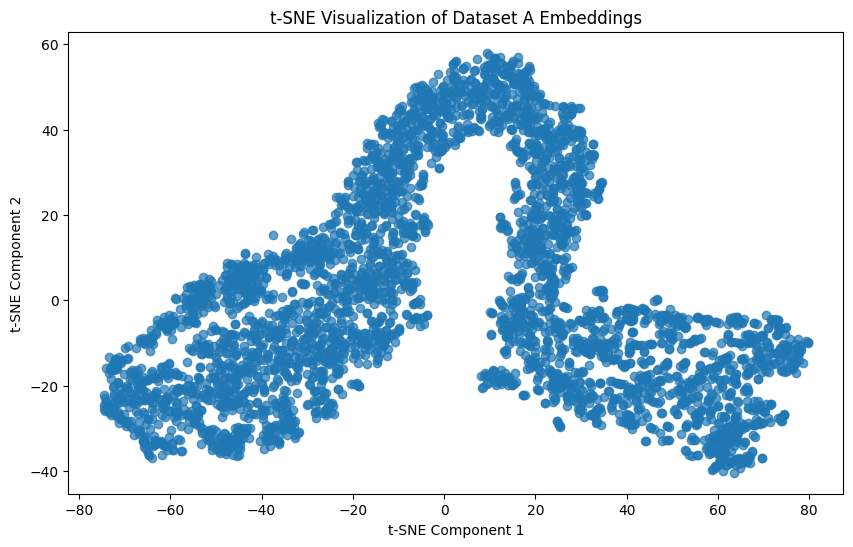

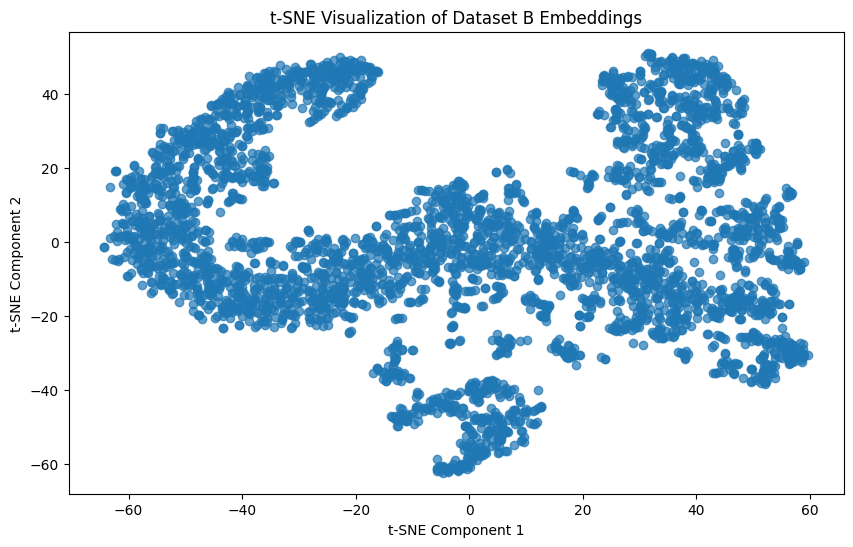

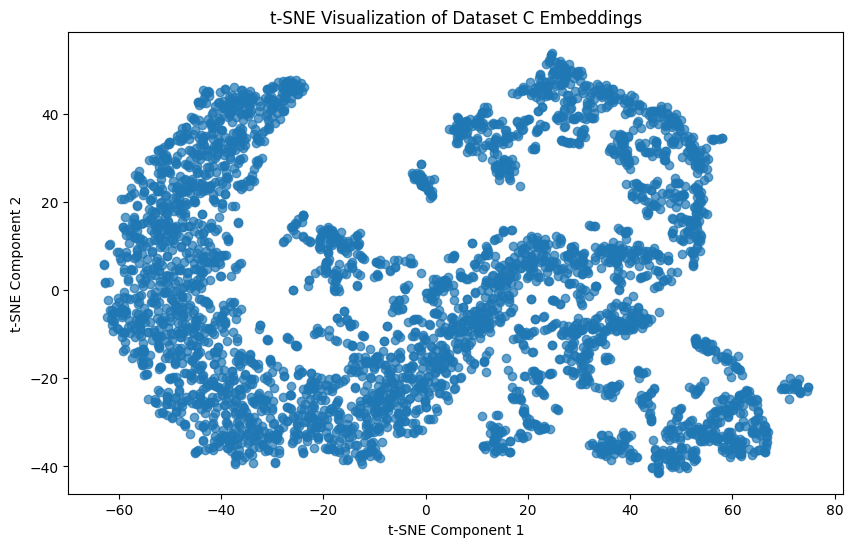

In [41]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define a function to compute and plot t-SNE embeddings
def plot_tsne(embeddings, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    plt.title(f"t-SNE Visualization of {title} Embeddings")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# Load patient embeddings for A, B, and C
embeddings_a = np.load("patient_embeddings_a.npy")
embeddings_b = np.load("patient_embeddings_b.npy")
embeddings_c = np.load("patient_embeddings_c.npy")

# Plot t-SNE for each dataset
plot_tsne(embeddings_a, "Dataset A")
plot_tsne(embeddings_b, "Dataset B")
plot_tsne(embeddings_c, "Dataset C")

# Supervised Training..

In [42]:
model.load_state_dict(torch.load("model_weights.pth"))  #load the model weights..
model.to(device)
model.eval()

LSTMEncoder(
  (lstm1): LSTM(41, 64, batch_first=True, dropout=0.3)
  (lstm2): LSTM(64, 32, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=32, out_features=32, bias=True)
)

In [43]:
#torch.save(model, "full_model.pth")  # Saves the entire model
model = torch.load("full_model.pth", weights_only=False)  # Load the saved model
model.eval()  # Set to evaluation mode

LSTMEncoder(
  (lstm): LSTM(41, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=32, bias=True)
)

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score

# Step 1: Load patient embeddings for df_a and df_c
embeddings_a = np.load("patient_embeddings_a.npy")  # Shape: (num_patients_a, embedding_size)
embeddings_c = np.load("patient_embeddings_c.npy")  # Shape: (num_patients_c, embedding_size)

# Step 2: Extract y_train for df_a and y_test for df_c
y_train_a = df_a.groupby('PatientID')['In_hospital_death'].last().values  # Shape: (num_patients_a,)
y_test_c = df_c.groupby('PatientID')['In_hospital_death'].last().values  # Shape: (num_patients_c,)

# Step 3: Train Logistic Regression on df_a embeddings
clf = LogisticRegression(max_iter=1000)  # Increase max_iter to ensure convergence.
clf.fit(embeddings_a, y_train_a)  # Train on embeddings_a

# Step 4: Evaluate the model using df_c embeddings
y_pred_c = clf.predict(embeddings_c)  # Predict on embeddings_c
y_pred_prob_c = clf.predict_proba(embeddings_c)[:, 1]  # Get predicted probabilities for the positive class

# Step 5: Evaluate Performance on df_c
accuracy = accuracy_score(y_test_c, y_pred_c)
print(f"Accuracy on df_c: {accuracy:.4f}")
print("Classification Report for df_c:\n", classification_report(y_test_c, y_pred_c))

# Step 6: Compute AuROC (Area under the ROC Curve)
auroc = roc_auc_score(y_test_c, y_pred_prob_c)
print(f"AuROC: {auroc:.4f}")

# Step 7: Compute AuPRC (Area under the Precision-Recall Curve)
auprc = average_precision_score(y_test_c, y_pred_prob_c)
print(f"AuPRC: {auprc:.4f}")

Accuracy on df_c: 0.8538
Classification Report for df_c:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92      3415
           1       0.00      0.00      0.00       585

    accuracy                           0.85      4000
   macro avg       0.43      0.50      0.46      4000
weighted avg       0.73      0.85      0.79      4000

AuROC: 0.5046
AuPRC: 0.1512


/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cluster/courses/ml4h/project1env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()